# Задание
Используя данные из обучающего датасета train.csv, построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели, предсказать цены для квартир из тестового датасета test.csv.

Целевая переменная: Price

Метрика качества: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению R2 > 0.6 Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример _solution.ipynb Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример _predictions.csv. Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).


In [40]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

# Описание датасета
Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

# Загрузка данных и оптимизация памяти

In [41]:
df = pd.read_csv(r'C:\Users\Игорь\Downloads\project_task (1)\project_task\train.csv')
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [42]:
df.shape

(10000, 20)

In [43]:
X_final = pd.read_csv(r'C:\Users\Игорь\Downloads\project_task (1)\test.csv')
X_final

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [44]:
def reduce_mem_usage(df):  
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df = reduce_mem_usage(df)
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


# Чтение данных

In [45]:
X = df.drop('Price', axis=1)
y = df[['Price']]


# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


10514

In [46]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

# Очистка данных

In [47]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # нежилая площадь
        not_LifeSquare = X['Square'] - X['LifeSquare']
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[(X['Rooms'] >= 6) & (X['LifeSquare'] < 100 ), 'Rooms'] = self.medians['Rooms'] 
        
         # Square 
        X.loc[(X['Square'] < 10) | (X['Square'] > 500), 'Square'] = self.medians['Square']
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'] < 3) & (X['KitchenSquare'] < (not_LifeSquare - 3)), 'KitchenSquare'] = 3
        X.loc[(X['KitchenSquare'] < 3) & (X['KitchenSquare'] > not_LifeSquare ), 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] > 100, 'KitchenSquare'] = X['KitchenSquare'].max()
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
# HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
    

        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X
        

In [48]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

# Функциональная инженерия

In [49]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.m_MedPriceByDistrict = None
        self.m_MedPriceByHouseYear = None
        self.m_MedPriceByHouseEcology_1 = None
        self.m_MedPriceByHouseSocial_1 = None
        self.m_MedPriceByHouseShops_1 = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 45]  
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
                        
        # Target encoding
        ## District
        df = X.copy()
        
        # медианная стоимость квадратного метра в зависимости от района
        if y is not None:
            df['Price'] = y.values
            df['m_Price'] = df['Price'] / df['Square'] # стоимость квадратного метра общей площади
            
            self.m_MedPriceByDistrict = df.groupby(['DistrictId'], as_index=False).agg({'m_Price':'median'})\
                    .rename(columns={'m_Price':'m_MedPriceByDistrict'})
        # медианная стоимость квадратного метра в зависимости от возраста дома
        if y is not None:
            df['Price'] = y.values
            df['m_Price'] = df['Price'] / df['Square']
            
            self.m_MedPriceByHouseYear = df.groupby(['HouseYear'], as_index=False).agg({'m_Price':'median'})\
                    .rename(columns={'m_Price':'m_MedPriceByHouseYear'})
            
        # медианная стоимость квадратного метра в зависимости от Ecology_1
        if y is not None:
            df['Price'] = y.values
            df['m_Price'] = df['Price'] / df['Square']
            
            self.m_MedPriceByHouseEcology_1 = df.groupby(['Ecology_1'], as_index=False).agg({'m_Price':'median'})\
                    .rename(columns={'m_Price':'m_MedPriceByHouseEcology_1'})
            
        # медианная стоимость квадратного метра в зависимости от Social_1
        if y is not None:
            df['Price'] = y.values
            df['m_Price'] = df['Price'] / df['Square']
            
            self.m_MedPriceByHouseSocial_1 = df.groupby(['Social_1'], as_index=False).agg({'m_Price':'median'})\
                    .rename(columns={'m_Price':'m_MedPriceByHouseSocial_1'})
            
        # медианная стоимость квадратного метра в зависимости от Shops_1
        if y is not None:
            df['Price'] = y.values
            df['m_Price'] = df['Price'] / df['Square']
            
            self.m_MedPriceByHouseShops_1 = df.groupby(['Shops_1'], as_index=False).agg({'m_Price':'median'})\
                    .rename(columns={'m_Price':'m_MedPriceByHouseShops_1'})
            
                   
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        
       
        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(2, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.m_MedPriceByDistrict is not None:
            X = X.merge(self.m_MedPriceByDistrict, on=['DistrictId'], how='left')
        if self.m_MedPriceByHouseYear is not None:
            X = X.merge(self.m_MedPriceByHouseYear, on=['HouseYear'], how='left')
        if self.m_MedPriceByHouseEcology_1 is not None:
            X = X.merge(self.m_MedPriceByHouseEcology_1, on=['Ecology_1'], how='left')
        if self.m_MedPriceByHouseSocial_1 is not None:
            X = X.merge(self.m_MedPriceByHouseSocial_1, on=['Social_1'], how='left')
        if self.m_MedPriceByHouseShops_1 is not None:
            X = X.merge(self.m_MedPriceByHouseShops_1, on=['Shops_1'], how='left')
        return X
    
    
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            

In [50]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [51]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,m_MedPriceByDistrict,m_MedPriceByHouseYear,m_MedPriceByHouseEcology_1,m_MedPriceByHouseSocial_1,m_MedPriceByHouseShops_1
0,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,1,...,1,3.0,3.0,NaN,181779.71875,4358.274902,4473.255371,4463.364258,4455.060547,4467.879883
1,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,1,...,0,3.0,3.0,300009.437500,181779.71875,4437.304199,4317.685059,4393.559570,4807.594727,4393.559570
2,53,2.0,44.947952,29.197611,3.0,8.0,12.0,1968,0.049637,1,...,0,3.0,3.0,263206.218750,181779.71875,4845.918945,4429.204102,4824.286133,4191.944824,4573.624512
3,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,1,...,0,3.0,3.0,166809.671875,181779.71875,2949.975342,2901.326416,2653.117676,4639.845703,4286.709961
4,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,1,...,0,4.0,3.0,158539.062500,179545.09375,3992.031250,4367.263184,3986.564941,4257.367676,3940.892578


In [52]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                 # 'Rooms_outlier', 
                   'HouseFloor_outlier', 
                  # 'HouseYear_outlier',
                   'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                   'm_MedPriceByHouseYear',
                   'm_MedPriceByDistrict',
                   'm_MedPriceByHouseEcology_1',
                   'm_MedPriceByHouseShops_1',
                   'm_MedPriceByHouseSocial_1',
                   'DistrictId_count', 
                   #'new_district', 
                  # 'Ecology_2', 
                   'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear']

X = X[remain_features]
X_final = X_final[remain_features]

In [53]:
model = LGBMRegressor(max_depth=7,
                             min_samples_leaf=20,
                             num_leaves = 30,
                             n_estimators=150,
                             bagging_fraction=1,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0

In [54]:
model.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


LGBMRegressor(bagging_fraction=1, max_depth=7, min_samples_leaf=20,
              n_estimators=150, num_leaves=30, random_state=42)

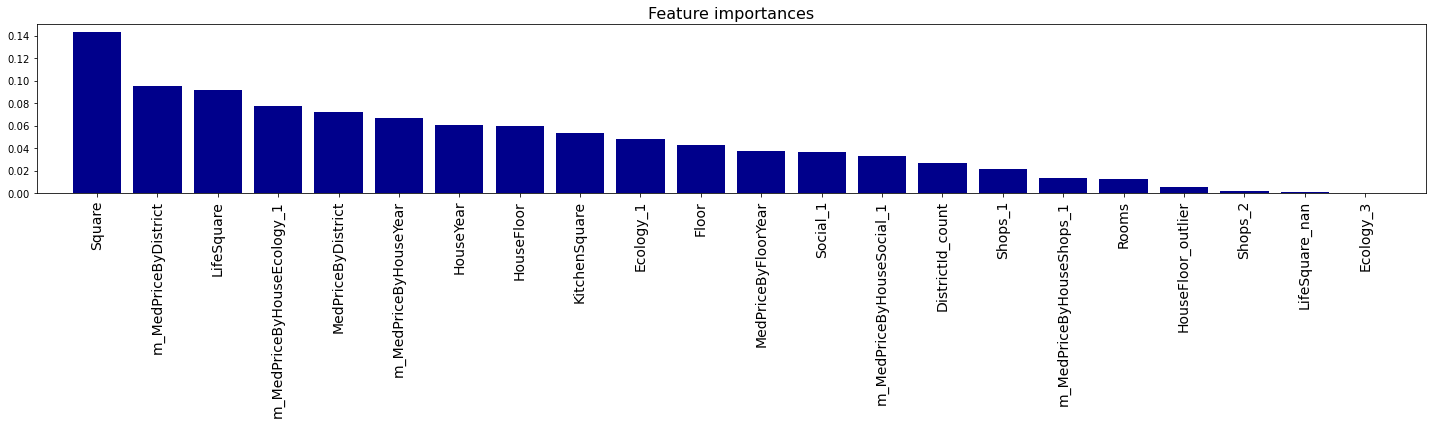

In [55]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)


In [56]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('Monpredictions.csv', index=False)

preds_final.head()


,Id,Price
0,725,158933.695241
1,15856,235375.789044
2,5480,166649.670774
3,15664,306110.277749
4,14275,141319.477467


# На сайте kaggle.com результат 0.74140